# **Modeling the mind of a predator: Interactive cognitive maps support flexible avoidance of dynamic threats**

### Toby Wise, Caroline J Charpentier, Peter Dayan & Dean Mobbs

## Analysis notebook 5 - Effects of unpredictability on planning

This notebook contains code for analyses of movement data in Experiment 3.

In [2]:
import pandas as pd
import seaborn as sns
import os
import pingouin as pg
import matplotlib.pyplot as plt
from maMDP.env_io import *
from maMDP.env_io import hex_environment_from_dict
from maMDP.plotting import plot_hex_grid_values
import sys
sys.path.append("../../code") 
import matplotlib
matplotlib.style.use('toby')
matplotlib.rcParams['font.weight'] = 'normal'
pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams["font.family"] = "Heebo"

C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.5, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Load in data

In [4]:
response_dfs = []

output_dir = '../../data/'
experiment = 'experiment-3'

data_dfs = {'response_data': response_dfs}

for data_type, df_list in data_dfs.items():
    
    data_type_dir = os.path.join(output_dir, data_type, experiment)
    
    conditions = os.listdir(data_type_dir)
    
    for c in conditions:
        for i in os.listdir(os.path.join(data_type_dir, c)):
            if '.csv' in i:
                df = pd.read_csv(os.path.join(data_type_dir, c, i))
                df_list.append(df)

response_df = pd.concat(response_dfs)

In [5]:
response_df.groupby(['condition', 'subjectID']).max().reset_index()['condition'].value_counts()

A1    80
A2    40
A3    40
B1    40
B2    40
B3    40
Name: condition, dtype: int64

## Load environment data

In [6]:
envs = {}
for cond in ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']:
    with open('../../data/game_info/experiment-3/condition_{0}.json'.format(cond), 'r') as f:
        game_info = json.load(f)
    envs[cond] = [hex_environment_from_dict(env, ['Dirt', 'Trees', 'Reward']) for env in game_info['environments'][2:]]

#### Remove training and practice environments

In [7]:
response_df = response_df[response_df['env'] > 1]

### Get predator/prey data

In [8]:
predator_df = response_df[response_df['agent'] == 'predator']
prey_df = response_df[response_df['agent'] == 'prey']

## Plot environments

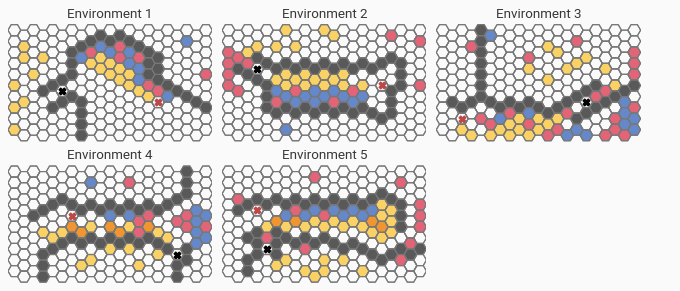

In [9]:
condition = 'A1'
n_envs = len(envs[condition])

f, ax = plt.subplots(2, 3, figsize=(10, 4))

for env in range(n_envs):
    
    envs[condition][env].plot(ax=ax[int(env / 3), env % 3], agent_plotting_kwargs={'s': 40}, agent_colours={'Predator_1': '#bd4848'}, colours=['#003cab', '#d40020', '#fab700'], alphas=[0.6] * 4)
    ax[int(env / 3), env % 3].set_title('Environment {0}'.format(env + 1))
    
ax[1, 2].set_axis_off()

plt.subplots_adjust(wspace=-0.2)
plt.savefig('../../figures/final2/Figure-5_Exp3A1_environments.svg')

## Get state occupancy

Here we plot two of the conditions (predictable and unpredictable conditions, long planning horizon) to demonstrate the constrast in behavioral patterns between the two.

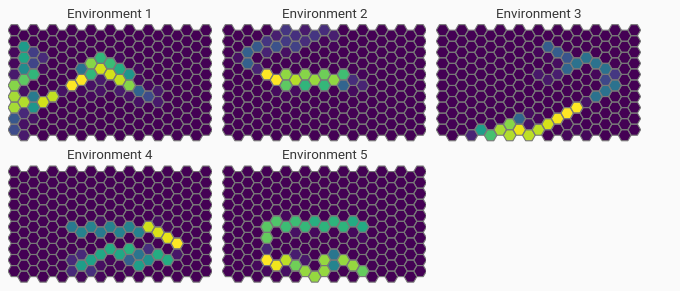

In [10]:
condition = 'A1'
n_envs = len(envs[condition])

occupancy_arrays = []

f, ax = plt.subplots(2, 3, figsize=(10, 4))

for env in range(n_envs):
    
    env_state_occupancy = np.zeros(envs[condition][env].mdp.shape)
    
    for state in prey_df.loc[(prey_df['env'] == env + 2) & (prey_df['condition'] == condition), 'cellID'].tolist():
        if state >= 0:
            env_state_occupancy[envs[condition][env].mdp.state_to_idx(state)] += 1
        
    occupancy_arrays.append(env_state_occupancy)
    
    plot_hex_grid_values(env_state_occupancy, ax=ax[int(env / 3), env % 3])
    ax[int(env / 3), env % 3].set_title('Environment {0}'.format(env + 1))
    
ax[1, 2].set_axis_off()
plt.subplots_adjust(wspace=-0.2)

plt.savefig('../../figures/Figure-5_Exp3A1_state_occupancy.svg')

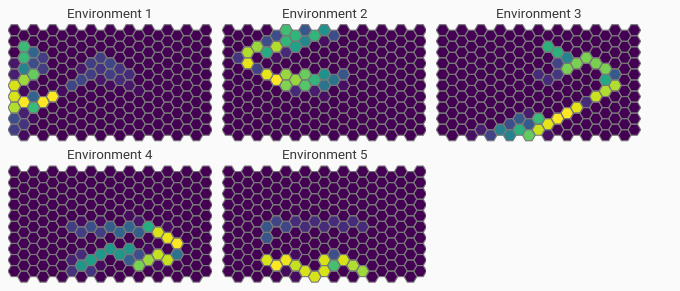

In [12]:
condition = 'A2'
n_envs = len(envs[condition])

occupancy_arrays = []

f, ax = plt.subplots(2, 3, figsize=(10, 4))

for env in range(n_envs):
    
    env_state_occupancy = np.zeros(envs[condition][env].mdp.shape)
    
    for state in prey_df.loc[(prey_df['env'] == env + 2) & (prey_df['condition'] == condition), 'cellID'].tolist():
        if state >= 0:
            env_state_occupancy[envs[condition][env].mdp.state_to_idx(state)] += 1
        
    occupancy_arrays.append(env_state_occupancy)
    
    plot_hex_grid_values(env_state_occupancy, ax=ax[int(env / 3), env % 3])
    ax[int(env / 3), env % 3].set_title('Environment {0}'.format(env + 1))
    
ax[1, 2].set_axis_off()
plt.subplots_adjust(wspace=-0.2)

plt.savefig('../../figures/Figure-5_Exp3A2_state_occupancy.svg')

## Calculate time spent in the rich reward zone

In [326]:
with open('../../data/env_data/exp-3_v3_rich_reward_zones.json', 'r') as f:
    rich_reward_idx = json.load(f)

time_in_rich_rewards = {'subjectID': [], 'env': [], 'count': [], 'condition': []}

for sub in prey_df['subjectID'].unique():
    for env in prey_df['env'].unique():
        sub_env_df = prey_df[(prey_df['subjectID'] == sub) & (prey_df['env'] == env)]
        time_in_rich_rewards['subjectID'].append(sub)
        time_in_rich_rewards['env'].append(env)
        time_in_rich_rewards['condition'].append(sub_env_df['condition'].values[0])
        time_in_rich_rewards['count'].append(np.isin(sub_env_df['cellID'].values, rich_reward_idx['env_{0}'.format(env - 1)]).sum())

time_in_rich_rewards = pd.DataFrame(time_in_rich_rewards)
print(time_in_rich_rewards['condition'].value_counts())

# Normalise
time_in_rich_rewards['max'] = 9
time_in_rich_rewards.loc[time_in_rich_rewards['env'] == 3, 'max'] = 11
time_in_rich_rewards.loc[time_in_rich_rewards['env'] == 4, 'max'] = 10
time_in_rich_rewards.loc[time_in_rich_rewards['env'] == 6, 'max'] = 11
time_in_rich_rewards['count_norm'] = time_in_rich_rewards['count'] / time_in_rich_rewards['max']
time_in_rich_rewards = time_in_rich_rewards.groupby(['subjectID', 'condition']).mean().reset_index()

time_in_rich_rewards['steps'] = 4
time_in_rich_rewards.loc[time_in_rich_rewards['condition'].str.contains('B'), 'steps'] = 1

time_in_rich_rewards['uncertainty'] = 'Predictable'
time_in_rich_rewards.loc[time_in_rich_rewards['condition'].str.contains('2'), 'uncertainty'] = 'Unpredictable'
time_in_rich_rewards.loc[time_in_rich_rewards['condition'].str.contains('3'), 'uncertainty'] = 'No RW'

time_in_rich_rewards.to_csv('../../data/exp-3_time_in_rich_rewards.csv', index=None)

# time_in_rich_rewards.to_csv('../../data/E3_rich_reward_count.csv', index=False)

A1    400
A2    200
A3    200
B1    200
B2    200
B3    200
Name: condition, dtype: int64


In [327]:
time_in_rich_rewards.head()

,subjectID,condition,env,count,max,count_norm,steps,uncertainty
0,sub0000,A1,4.0,5.2,10.0,0.519596,4,Predictable
1,sub0001,A1,4.0,6.4,10.0,0.644444,4,Predictable
2,sub0002,A1,4.0,4.4,10.0,0.426263,4,Predictable
3,sub0003,A1,4.0,9.2,10.0,0.915556,4,Predictable
4,sub0004,A1,4.0,3.8,10.0,0.386061,4,Predictable


## Plot time spent in rich reward zones across all conditions

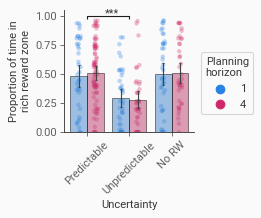

In [25]:
f, ax = plt.subplots(1, 1, figsize=(3.3, 2.8))

sns.stripplot(x='uncertainty', y='count_norm', hue='Planning\nhorizon', data=time_in_rich_rewards.rename(columns={'steps': 'Planning\nhorizon'}), alpha=0.3, zorder=-1, dodge=True, s=4)
sns.barplot(x='uncertainty', y='count_norm', hue='Planning\nhorizon', data=time_in_rich_rewards.rename(columns={'steps': 'Planning\nhorizon'}), alpha=0.5, capsize=.05, errwidth=1, linewidth=.8, edgecolor='black')
plt.xticks(rotation=45)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title='Planning\nhorizon', bbox_to_anchor=(1.01, 0.7))

plt.plot([0, 0, 1, 1], [.97, 1, 1, .97], color='#1c1c1c')
plt.text(0.42, 1, '***')

plt.xlabel('Uncertainty')
plt.ylabel('Proportion of time in\nrich reward zone')

sns.despine()

plt.tight_layout()

plt.savefig('../../figures/Figure-5_Exp3_rich_reward_proportions.svg')

## Run an ANOVA to test effects of planning horizon and uncertainty

In [329]:
time_in_rich_rewards.anova('count_norm', between=['uncertainty', 'steps']).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,uncertainty,2.714,2.0,1.357,17.704,0.000,0.114
1,steps,0.002,1.0,0.002,0.027,0.869,0.000
2,uncertainty * steps,0.015,2.0,0.008,0.099,0.906,0.001
3,Residual,21.003,274.0,0.077,NaN,NaN,NaN


## Run planned contrasts

In [27]:
contrasts = time_in_rich_rewards.pairwise_ttests(dv='count_norm', between=['uncertainty', 'steps'], effsize='cohen').iloc[[0, 1]]
contrasts['p-adj'] = pg.multicomp(contrasts['p-unc'].values, method='bonf')[1]

In [330]:
contrasts.round(3)

,Contrast,uncertainty,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen,p-adj
0,uncertainty,-,Predictable,Unpredictable,False,True,5.778,182.531,two-sided,0.000,3.773e+05,0.814,0.0
1,uncertainty,-,Predictable,No RW,False,True,-0.121,162.371,two-sided,0.904,0.158,-0.018,1.0


## Set up model fitting

First we create a dataframe of parameter values to try in the model fitting procedure.

In [29]:
softmax_temperature = np.linspace(0, .75, 10)
softmax_temperature[0] = 1e-5
models = ['MCTS_interactive'] 

from itertools import product

param_list = list(product(models, softmax_temperature))
param_list.append(('null_model', -1))
planning_model_params = pd.DataFrame(param_list, columns=['model', 'softmax_temperature'])
planning_model_params['C'] = 5
planning_model_params['experiment'] = 3
planning_model_params['condition'] = 'A1'
planning_model_params['n_moves'] = 4
planning_model_params['max_planning_steps'] = 12  # Total number of moves

sub_param_dfs = []

for sub in prey_df.loc[prey_df['condition'] == 'A1', 'subjectID'].unique():
    sub_param_df = planning_model_params.copy()
    sub_param_df['subjectID'] = sub
    sub_param_dfs.append(sub_param_df)
    
planning_model_params = pd.concat(sub_param_dfs).reset_index(drop=True)

planning_model_params.to_csv('../../data/planning_model_softmax_fit_runs.csv', index=False)

And the same for the unpredictable condition

In [35]:
sub_param_dfs = []

planning_model_params = pd.DataFrame(param_list, columns=['model', 'softmax_temperature'])
planning_model_params['C'] = 5
planning_model_params['experiment'] = 3
planning_model_params['condition'] = 'A2'
planning_model_params['n_moves'] = 4
planning_model_params['max_planning_steps'] = 12  # Total number of moves

for sub in prey_df.loc[prey_df['condition'] == 'A2', 'subjectID'].unique():
    sub_param_df = planning_model_params.copy()
    sub_param_df['subjectID'] = sub
    sub_param_dfs.append(sub_param_df)
    
planning_model_params = pd.concat(sub_param_dfs).reset_index(drop=True)

planning_model_params.to_csv('../../data/planning_model_softmax_fit_runs_condition-A2.csv', index=False)

## Model fitting

All the MCTS models are fit using the `run_mcts_IBS_fit.py` script in the `~/code` directory, supplying the desired parameter file as created above to determine the data used and the range of parameter values evaluated. This is fairly computationally intensive, so this procedure is run independently of this notebook to take advantage of HPC parallel computing.

## Load in model fits

Here we gather the outputs of the model fitting (run in a separate script) and put them into a dataframe

In [331]:
fit_dir = '../../data/softmax_IBS_fits/IBS_fits/experiment_3/condition_A1/'

fits = pd.concat([pd.read_csv(os.path.join(fit_dir, i)) for i in os.listdir(fit_dir) if '.csv' in i])
fits = fits[fits['model'] == 'MCTS_interactive']
fits = fits[fits['environment'] > 1]  # Exclude the practice environment

In [305]:
fits.head()

,environment,ll,subjectID,n_repeats,stopping_point,start_time,time_taken,softmax_temperature,model,C
1,2,-0.170573,sub0000,16,6,20/09/2021 07:06:52,2345.216228,0.00001,MCTS_interactive,5
2,3,-0.699219,sub0000,16,6,20/09/2021 07:06:52,2345.216228,0.00001,MCTS_interactive,5
3,4,0.000000,sub0000,16,6,20/09/2021 07:06:52,2345.216228,0.00001,MCTS_interactive,5
4,5,0.000000,sub0000,16,6,20/09/2021 07:06:52,2345.216228,0.00001,MCTS_interactive,5
5,6,-0.062500,sub0000,16,6,20/09/2021 07:06:52,2345.216228,0.00001,MCTS_interactive,5


### Find the best fitting softmax temperature for each subject

In [332]:
fits_sum = fits.groupby(['subjectID', 'softmax_temperature']).sum().reset_index()
best_fit_temp = fits_sum.loc[fits_sum['ll'] == fits_sum.groupby('subjectID')['ll'].transform('max'), ['subjectID', 'softmax_temperature']].reset_index(drop=True)

### Find the best fitting softmax temperature for each subject in each game

In [336]:
dfs = []

for sub in fits['subjectID'].unique():
    for env in fits['environment'].unique():
        sub_env_df = fits[(fits['subjectID'] == sub) & (fits['environment'] == env)]
        best_value = sub_env_df.loc[sub_env_df['ll'] == sub_env_df['ll'].max(), ['subjectID', 'softmax_temperature', 'environment']]
        if len(best_value) > 1:
            best_value = best_value[best_value['softmax_temperature'] == np.sort(best_value['softmax_temperature'])[int(len(best_value['softmax_temperature']) / 2)]]  # if multiple best fitting values
        dfs.append(best_value)
        
best_fit_temp_env = pd.concat(dfs).reset_index(drop=True).copy()

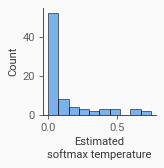

In [310]:
plt.figure(figsize=(2.2, 2.2))
plt.hist(best_fit_temp['softmax_temperature'], alpha=0.6, linewidth=.8, edgecolor='black')

plt.ylabel('Count')
plt.xlabel('Estimated\nsoftmax temperature')
sns.despine()
plt.tight_layout()
plt.savefig('../../figures/Figure-5_Exp3_softmax_temperature.svg')

### Test whether a significant number of subjects have softmax temperatures of > 0

In [379]:
from statsmodels.stats.proportion import proportions_ztest
z, p = proportions_ztest((best_fit_temp['softmax_temperature'] > 0.001).sum(), len(best_fit_temp), 0)

print('Z = {0}, p = {1}'.format(np.round(z, 2), np.round(p, 3)))

Z = 6.56, p = 0.0


And find how many subjects have temperatures > 0

In [313]:
(best_fit_temp['softmax_temperature'] > 0.001).sum() / len(best_fit_temp)

0.35

### Calculate the mean time spent in the rich reward zone for each subject

In [381]:
mean_time_in_rich_rewards = time_in_rich_rewards[time_in_rich_rewards['condition'] == 'A1'].groupby('subjectID').mean().reset_index()
mean_time_in_rich_rewards.head()

,subjectID,env,count,max,count_norm,steps
0,sub0000,4.0,5.2,10.0,0.519596,4.0
1,sub0001,4.0,6.4,10.0,0.644444,4.0
2,sub0002,4.0,4.4,10.0,0.426263,4.0
3,sub0003,4.0,9.2,10.0,0.915556,4.0
4,sub0004,4.0,3.8,10.0,0.386061,4.0


### Calculate correlations between softmax temperature and time spent in rich reward zone

In [384]:
from scipy.stats import pearsonr, spearmanr

nsubs = len(best_fit_temp['softmax_temperature'])
r, p = pearsonr(best_fit_temp['softmax_temperature'], mean_time_in_rich_rewards['count_norm'])
print('r({0})={1}, p={2}'.format(nsubs-2, np.round(r, 2), np.round(p, 3)))

r(78)=-0.6, p=0.0


In [385]:
nsubs = len(best_fit_temp['softmax_temperature'])
r, p = spearmanr(best_fit_temp['softmax_temperature'], mean_time_in_rich_rewards['count_norm'])
print('rho({0})={1}, p={2}'.format(nsubs-2, np.round(r, 2), np.round(p, 3)))

rho(78)=-0.73, p=0.0


### Plot

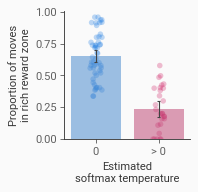

In [341]:
best_fit_temp['nonzero'] = best_fit_temp['softmax_temperature'] > .001
best_fit_temp['nonzero'] = best_fit_temp['nonzero'].replace({False: '0', True: '> 0'})
best_fit_temp = pd.merge(best_fit_temp, mean_time_in_rich_rewards[['subjectID', 'count_norm']])

f, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))

sns.stripplot(x='nonzero', y='count_norm', data=best_fit_temp.rename(columns={'steps': 'Planning\nhorizon'}), alpha=0.3, zorder=-1, dodge=True)
sns.barplot(x='nonzero', y='count_norm', data=best_fit_temp.rename(columns={'steps': 'Planning\nhorizon'}), alpha=0.5, capsize=.05, errwidth=1)

plt.xlabel('Estimated\nsoftmax temperature')
plt.ylabel('Proportion of moves\nin rich reward zone')

sns.despine()

plt.tight_layout()


## Unpredictable condition

Then we repeat these analyses for the unpredictable condition

In [342]:
fit_dir = '../../data/softmax_IBS_fits_A2/IBS_fits/experiment_3/condition_A2/'

fits_A2 = pd.concat([pd.read_csv(os.path.join(fit_dir, i)) for i in os.listdir(fit_dir) if '.csv' in i])
fits_A2 = fits_A2[fits_A2['model'] == 'MCTS_interactive']
fits_A2 = fits_A2[fits_A2['environment'] > 1]

In [343]:
fits_A2.head()

,environment,ll,subjectID,n_repeats,stopping_point,start_time,time_taken,softmax_temperature,model,C
1,2,-2.066406,sub0081,16,6,30/12/2021 02:21:28,3493.667887,0.00001,MCTS_interactive,5
2,3,-0.665365,sub0081,16,6,30/12/2021 02:21:28,3493.667887,0.00001,MCTS_interactive,5
3,4,0.000000,sub0081,16,6,30/12/2021 02:21:28,3493.667887,0.00001,MCTS_interactive,5
4,5,-0.473958,sub0081,16,6,30/12/2021 02:21:28,3493.667887,0.00001,MCTS_interactive,5
5,6,-0.138021,sub0081,16,6,30/12/2021 02:21:28,3493.667887,0.00001,MCTS_interactive,5


### Find the best fitting softmax temperature for each subject

In [344]:
fits_sum_A2 = fits_A2.groupby(['subjectID', 'softmax_temperature']).sum().reset_index()
best_fit_temp_A2 = fits_sum_A2.loc[fits_sum_A2['ll'] == fits_sum_A2.groupby('subjectID')['ll'].transform('max'), ['subjectID', 'softmax_temperature']].reset_index(drop=True)

### Find the best fitting softmax temperature for each subject in each game

In [345]:
dfs = []

for sub in fits_A2['subjectID'].unique():
    for env in fits_A2['environment'].unique():
        sub_env_df = fits_A2[(fits_A2['subjectID'] == sub) & (fits_A2['environment'] == env)]
        best_value = sub_env_df.loc[sub_env_df['ll'] == sub_env_df['ll'].max(), ['subjectID', 'softmax_temperature', 'environment']]
        if len(best_value) > 1:
            best_value = best_value[best_value['softmax_temperature'] == np.sort(best_value['softmax_temperature'])[int(len(best_value['softmax_temperature']) / 2)]]  # if multiple best fitting values
        dfs.append(best_value)
        
best_fit_temp_env_A2 = pd.concat(dfs).reset_index(drop=True).copy()

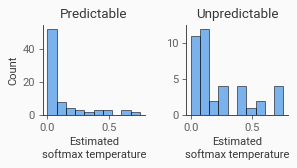

In [346]:
f, ax = plt.subplots(1, 2, figsize=(3.8, 2.2))
ax[0].hist(best_fit_temp['softmax_temperature'], alpha=0.6, linewidth=.8, edgecolor='black')
ax[1].hist(best_fit_temp_A2['softmax_temperature'], alpha=0.6, linewidth=.8, edgecolor='black')

ax[0].set_title('Predictable')
ax[1].set_title('Unpredictable')

ax[0].set_ylabel('Count')
ax[0].set_xlabel('Estimated\nsoftmax temperature')
ax[1].set_xlabel('Estimated\nsoftmax temperature')
sns.despine()
plt.tight_layout()
plt.savefig('../../figures/Figure-5_Exp3_softmax_temperature_both_conditions.svg')

### Compare estimated values between conditions

Using Mann-Whitney U as the data is highly skewed

In [353]:
pg.mwu(best_fit_temp_A2['softmax_temperature'].values, best_fit_temp['softmax_temperature'].values)

,U-val,tail,p-val,RBC,CLES
MWU,2165.5,two-sided,0.000646,-0.353438,0.565625


### Calculate the mean time spent in the rich reward zone for each subject

In [386]:
mean_time_in_rich_rewards = time_in_rich_rewards[time_in_rich_rewards['condition'] == 'A2'].groupby('subjectID').mean().reset_index()

### Calculate correlation between softmax temperature and time spent in rich reward zone

In [387]:
from scipy.stats import pearsonr

nsubs = len(best_fit_temp_A2['softmax_temperature'])
r, p = pearsonr(best_fit_temp_A2['softmax_temperature'], mean_time_in_rich_rewards['count_norm'])
print('r({0})={1}, p={2}'.format(nsubs-2, np.round(r, 2), np.round(p, 3)))

r(38)=-0.53, p=0.0


### Plot effect for both conditions

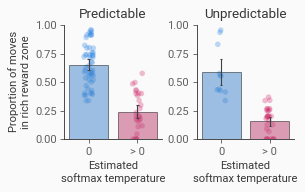

In [351]:
best_fit_temp_A2['nonzero'] = best_fit_temp_A2['softmax_temperature'] > .001
best_fit_temp_A2['nonzero'] = best_fit_temp_A2['nonzero'].replace({False: '0', True: '> 0'})
best_fit_temp_A2 = pd.merge(best_fit_temp_A2, mean_time_in_rich_rewards[['subjectID', 'count_norm']])

f, ax = plt.subplots(1, 2, figsize=(3.8, 2.5))

sns.stripplot(x='nonzero', y='count_norm', data=best_fit_temp.rename(columns={'steps': 'Planning\nhorizon'}), alpha=0.3, zorder=-1, dodge=True, ax=ax[0])
sns.barplot(x='nonzero', y='count_norm', data=best_fit_temp.rename(columns={'steps': 'Planning\nhorizon'}), alpha=0.5, capsize=.05, errwidth=1, ax=ax[0], linewidth=.8, edgecolor='black')

sns.stripplot(x='nonzero', y='count_norm', data=best_fit_temp_A2.sort_values('nonzero').rename(columns={'steps': 'Planning\nhorizon'}), alpha=0.3, zorder=-1, dodge=True, ax=ax[1])
sns.barplot(x='nonzero', y='count_norm', data=best_fit_temp_A2.sort_values('nonzero').rename(columns={'steps': 'Planning\nhorizon'}), alpha=0.5, capsize=.05, errwidth=1, ax=ax[1], linewidth=.8, edgecolor='black')

ax[0].set_xlabel('Estimated\nsoftmax temperature')
ax[0].set_ylabel('Proportion of moves\nin rich reward zone')

ax[1].set_xlabel('Estimated\nsoftmax temperature')
ax[1].set_ylabel('')

ax[0].set_title('Predictable')
ax[1].set_title('Unpredictable')

sns.despine()

plt.tight_layout()

plt.savefig('../../figures/Figure-5_Exp3_softmax_temperature_behavior_barplot_both_conditions.svg')

### Look at trends across games

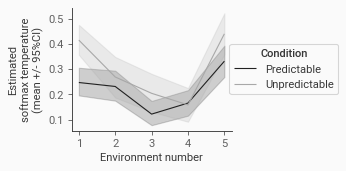

In [375]:
plt.figure(figsize=(2.3, 1.9))
sns.lineplot(x='environment', y='softmax_temperature', data=best_fit_temp_env, label='Predictable', color='#212121')
sns.lineplot(x='environment', y='softmax_temperature', data=best_fit_temp_env_A2, label='Unpredictable', color='#a8a8a8')
plt.ylabel('Estimated\nsoftmax temperature\n(mean +/- 95%CI)')
plt.xlabel('Environment number')
plt.xticks(range(2, 7), range(1, 6))
legend = plt.legend(title='Condition', loc='center right', bbox_to_anchor=(1.7, .5))
plt.setp(legend.get_title(),fontweight='medium')
sns.despine()
# plt.tight_layout()

plt.savefig('../../figures/Figure-5_Exp3_softmax_temperature_environments.pdf')

In [359]:
lm = pg.linear_regression(best_fit_temp_env['environment'], best_fit_temp_env['softmax_temperature'])
lm_A2 = pg.linear_regression(best_fit_temp_env_A2['environment'], best_fit_temp_env_A2['softmax_temperature'])

In [360]:
lm.round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.178,0.040,4.448,0.000,0.003,0.0,0.099,0.257
1,environment,0.010,0.009,1.093,0.275,0.003,0.0,-0.008,0.029


In [362]:
lm_A2.round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.321,0.057,5.666,0.000,0.001,-0.004,0.209,0.433
1,environment,-0.006,0.013,-0.452,0.652,0.001,-0.004,-0.032,0.020
